In [156]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import torchmetrics

In [157]:
seed = 333
torch.random.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device="cuda"

batch_size = 4
root_path = "/home/stefan/ioai-prep/kits/roai-2025/skeletons"

# Data preparation

In [158]:
class MovementDataset(Dataset):
    def __init__(self, df_path: str):
        self.df = pd.read_csv(df_path)

        self.unique_ids = self.df["IDSample"].nunique()
        self.start_idx = self.df.iloc[0]["IDSample"]

    def len_frames(self, idx):
        row_idx = int(idx + self.start_idx)
        rows = self.df[self.df["IDSample"] == row_idx]
        return len(rows)
    
    def __getitem__(self, idx):
        row_idx = int(idx + self.start_idx)
        rows = self.df[self.df["IDSample"] == row_idx]

        cols = [f"J{i}X" for i in range(1, 25+1)] + [f"J{i}Y" for i in range(1, 25+1)] + [f"J{i}Z" for i in range(1, 25+1)]
        data = rows[cols].values.reshape(-1, 25 * 3)
        data = torch.tensor(data, dtype=torch.float32)

        if "Camera" in rows:
            labels = rows.iloc[0][["Camera", "Action"]].values
            labels[0] -= 1
            labels = torch.tensor(labels, dtype=torch.long).reshape(1, 2)

            return data, labels
        return data
    
    def __len__(self):
        return self.unique_ids

In [159]:
def collate_fn(batch):
    data, labels = zip(*batch)
    data_padded = pad_sequence(data, batch_first=True)
    labels = torch.stack(labels, dim=0)
    return data_padded, labels

In [160]:
dataset_train = MovementDataset(f"{root_path}/train_data.csv")
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)

In [161]:
batch = next(iter(dataloader_train))

# (batch_size, seq_len, 75); (batch_size, 1, 2)
# data; lengths; labels
[b.shape for b in batch]

[torch.Size([4, 178, 75]), torch.Size([4, 1, 2])]

# Model

In [162]:
class SkeletonNet(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()

        self.n_hidden = 128
        self.n_layers = 2

        self.lstm = nn.LSTM(input_size=75, hidden_size=self.n_hidden, num_layers=self.n_layers, batch_first=True)
        self.head = nn.LazyLinear(num_classes)

    def forward(self, x):
        # x.shape = (batch_size, seq_len, n_hidden)
        batch_size = x.shape[0]

        features, _ = self.lstm(x)
        features = torch.mean(features, dim=1)

        features = features.view(batch_size, -1)

        pred = self.head(features)
        return pred

In [163]:
num_action_classes = 5
num_camera_classes = 3

In [164]:
test_model = SkeletonNet(2).to(device)

b = batch[0].to(device)
test_model(b)[1].shape

torch.Size([2])

# Training

In [165]:
should_train = True

In [166]:
def train(num_classes: int, epochs: int, base_lr: float, T_0: int, lr_min: float):
    model = SkeletonNet(num_classes).to(device)
    losses = []

    label_idx = 0 if num_classes == 3 else 1
    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)

    criterion_action = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=base_lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=T_0, eta_min=lr_min)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (data, labels) in enumerate(tqdm(dataloader_train)):
            data, labels = data.to(device), labels.to(device)

            # forward pass
            logits = model(data)
            loss = criterion_action(logits, labels[:, :, label_idx].squeeze(-1))

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 2.5)
            optimizer.step()
            scheduler.step((0+epoch) + i / len(dataloader_train))

            # stats
            running_loss += loss.item()
            losses.append(loss.item())
            accuracy(logits, labels[:, :, label_idx].squeeze(-1))
        
        l = running_loss / len(dataloader_train)
        acc = accuracy.compute()

        print(f"Epoch {epoch}, loss={l:.2f}, acc={(acc*100):.1f}%")
    
    return model, losses

In [167]:
hyperparams = {
    "action": {
        "epochs": 60,
        "base_lr": 5e-4,
        "T_0": 5,
        "lr_min": 1e-6,
    },

    "camera": {
        "epochs": 90,
        "base_lr": 2e-4,
        "T_0": 90,
        "lr_min": 1e-6,
    }
}

In [168]:
if should_train:
    print("Training the action model.")
    model_action, losses_action = train(num_action_classes, **hyperparams["action"])
    torch.save(model_action.state_dict(), "action.pth")
else:
    model_action = SkeletonNet(num_action_classes).to(device)
    model_action.load_state_dict(torch.load("action.pth"))

Training the action model.


100%|██████████| 838/838 [00:06<00:00, 135.76it/s]


Epoch 0, loss=1.23, acc=46.5%


100%|██████████| 838/838 [00:06<00:00, 130.51it/s]


Epoch 1, loss=0.78, acc=58.2%


100%|██████████| 838/838 [00:06<00:00, 125.89it/s]


Epoch 2, loss=0.53, acc=65.8%


100%|██████████| 838/838 [00:06<00:00, 130.30it/s]


Epoch 3, loss=0.37, acc=71.2%


100%|██████████| 838/838 [00:06<00:00, 135.14it/s]


Epoch 4, loss=0.28, acc=75.2%


100%|██████████| 838/838 [00:06<00:00, 131.60it/s]


Epoch 5, loss=0.45, acc=76.8%


100%|██████████| 838/838 [00:06<00:00, 134.58it/s]


Epoch 6, loss=0.29, acc=78.9%


100%|██████████| 838/838 [00:06<00:00, 127.19it/s]


Epoch 7, loss=0.25, acc=80.7%


100%|██████████| 838/838 [00:06<00:00, 128.45it/s]


Epoch 8, loss=0.14, acc=82.3%


100%|██████████| 838/838 [00:06<00:00, 132.15it/s]


Epoch 9, loss=0.10, acc=83.8%


100%|██████████| 838/838 [00:06<00:00, 130.66it/s]


Epoch 10, loss=0.29, acc=84.5%


100%|██████████| 838/838 [00:06<00:00, 134.75it/s]


Epoch 11, loss=0.22, acc=85.3%


100%|██████████| 838/838 [00:06<00:00, 126.61it/s]


Epoch 12, loss=0.14, acc=86.1%


100%|██████████| 838/838 [00:06<00:00, 132.52it/s]


Epoch 13, loss=0.12, acc=86.9%


100%|██████████| 838/838 [00:06<00:00, 132.83it/s]


Epoch 14, loss=0.07, acc=87.6%


100%|██████████| 838/838 [00:06<00:00, 134.34it/s]


Epoch 15, loss=0.27, acc=87.9%


100%|██████████| 838/838 [00:06<00:00, 135.84it/s]


Epoch 16, loss=0.19, acc=88.3%


100%|██████████| 838/838 [00:06<00:00, 133.03it/s]


Epoch 17, loss=0.10, acc=88.8%


100%|██████████| 838/838 [00:06<00:00, 127.14it/s]


Epoch 18, loss=0.07, acc=89.3%


100%|██████████| 838/838 [00:06<00:00, 133.78it/s]


Epoch 19, loss=0.05, acc=89.8%


100%|██████████| 838/838 [00:06<00:00, 138.59it/s]


Epoch 20, loss=0.21, acc=90.0%


100%|██████████| 838/838 [00:06<00:00, 123.58it/s]


Epoch 21, loss=0.13, acc=90.3%


100%|██████████| 838/838 [00:06<00:00, 129.30it/s]


Epoch 22, loss=0.08, acc=90.7%


100%|██████████| 838/838 [00:06<00:00, 130.78it/s]


Epoch 23, loss=0.05, acc=91.0%


100%|██████████| 838/838 [00:06<00:00, 121.78it/s]


Epoch 24, loss=0.04, acc=91.3%


100%|██████████| 838/838 [00:06<00:00, 122.89it/s]


Epoch 25, loss=0.18, acc=91.4%


100%|██████████| 838/838 [00:06<00:00, 129.42it/s]


Epoch 26, loss=0.10, acc=91.6%


100%|██████████| 838/838 [00:06<00:00, 128.53it/s]


Epoch 27, loss=0.06, acc=91.9%


100%|██████████| 838/838 [00:06<00:00, 131.09it/s]


Epoch 28, loss=0.04, acc=92.1%


100%|██████████| 838/838 [00:06<00:00, 127.76it/s]


Epoch 29, loss=0.02, acc=92.4%


100%|██████████| 838/838 [00:06<00:00, 133.67it/s]


Epoch 30, loss=0.15, acc=92.5%


100%|██████████| 838/838 [00:06<00:00, 137.25it/s]


Epoch 31, loss=0.10, acc=92.7%


100%|██████████| 838/838 [00:06<00:00, 125.59it/s]


Epoch 32, loss=0.05, acc=92.8%


100%|██████████| 838/838 [00:06<00:00, 124.58it/s]


Epoch 33, loss=0.03, acc=93.0%


100%|██████████| 838/838 [00:06<00:00, 129.59it/s]


Epoch 34, loss=0.02, acc=93.2%


100%|██████████| 838/838 [00:06<00:00, 134.87it/s]


Epoch 35, loss=0.14, acc=93.3%


100%|██████████| 838/838 [00:06<00:00, 135.62it/s]


Epoch 36, loss=0.06, acc=93.4%


100%|██████████| 838/838 [00:06<00:00, 135.86it/s]


Epoch 37, loss=0.03, acc=93.6%


100%|██████████| 838/838 [00:06<00:00, 132.40it/s]


Epoch 38, loss=0.02, acc=93.7%


100%|██████████| 838/838 [00:06<00:00, 136.53it/s]


Epoch 39, loss=0.01, acc=93.9%


100%|██████████| 838/838 [00:06<00:00, 139.30it/s]


Epoch 40, loss=0.15, acc=93.9%


100%|██████████| 838/838 [00:06<00:00, 132.63it/s]


Epoch 41, loss=0.05, acc=94.1%


100%|██████████| 838/838 [00:06<00:00, 139.46it/s]


Epoch 42, loss=0.03, acc=94.2%


100%|██████████| 838/838 [00:06<00:00, 135.26it/s]


Epoch 43, loss=0.02, acc=94.3%


100%|██████████| 838/838 [00:06<00:00, 137.52it/s]


Epoch 44, loss=0.01, acc=94.4%


100%|██████████| 838/838 [00:06<00:00, 133.26it/s]


Epoch 45, loss=0.13, acc=94.5%


100%|██████████| 838/838 [00:06<00:00, 132.00it/s]


Epoch 46, loss=0.05, acc=94.6%


100%|██████████| 838/838 [00:06<00:00, 133.39it/s]


Epoch 47, loss=0.03, acc=94.7%


100%|██████████| 838/838 [00:06<00:00, 134.29it/s]


Epoch 48, loss=0.02, acc=94.8%


100%|██████████| 838/838 [00:06<00:00, 134.82it/s]


Epoch 49, loss=0.01, acc=94.9%


100%|██████████| 838/838 [00:06<00:00, 130.47it/s]


Epoch 50, loss=0.09, acc=94.9%


100%|██████████| 838/838 [00:06<00:00, 133.83it/s]


Epoch 51, loss=0.07, acc=95.0%


100%|██████████| 838/838 [00:06<00:00, 135.79it/s]


Epoch 52, loss=0.03, acc=95.1%


100%|██████████| 838/838 [00:05<00:00, 140.08it/s]


Epoch 53, loss=0.01, acc=95.1%


100%|██████████| 838/838 [00:06<00:00, 132.31it/s]


Epoch 54, loss=0.01, acc=95.2%


100%|██████████| 838/838 [00:06<00:00, 126.14it/s]


Epoch 55, loss=0.09, acc=95.3%


100%|██████████| 838/838 [00:06<00:00, 126.36it/s]


Epoch 56, loss=0.04, acc=95.3%


100%|██████████| 838/838 [00:06<00:00, 126.70it/s]


Epoch 57, loss=0.02, acc=95.4%


100%|██████████| 838/838 [00:06<00:00, 135.52it/s]


Epoch 58, loss=0.01, acc=95.5%


100%|██████████| 838/838 [00:05<00:00, 140.96it/s]

Epoch 59, loss=0.00, acc=95.6%


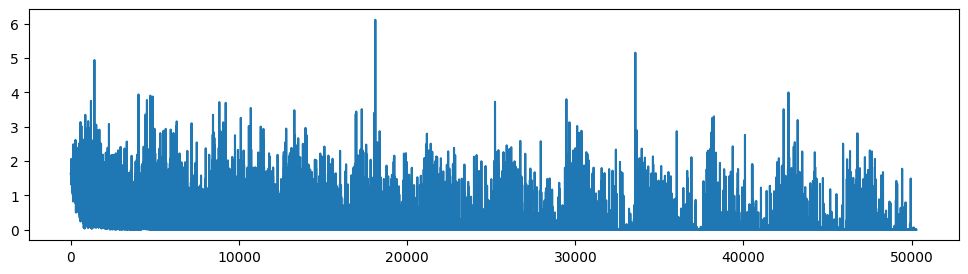

In [169]:
if losses_action is not None:
    plt.figure(figsize=(12, 3))
    plt.plot(losses_action)

In [170]:
if should_train:
    print("Training the camera model.")
    model_camera, losses_camera = train(num_camera_classes, **hyperparams["camera"])
    torch.save(model_action.state_dict(), "camera.pth")
else:
    model_camera = SkeletonNet(num_camera_classes).to(device)
    model_camera.load_state_dict(torch.load("camera.pth"))

Training the camera model.


100%|██████████| 838/838 [00:06<00:00, 135.98it/s]


Epoch 0, loss=1.05, acc=42.7%


100%|██████████| 838/838 [00:06<00:00, 137.44it/s]


Epoch 1, loss=1.01, acc=45.5%


100%|██████████| 838/838 [00:06<00:00, 130.19it/s]


Epoch 2, loss=0.98, acc=47.4%


100%|██████████| 838/838 [00:06<00:00, 126.76it/s]


Epoch 3, loss=0.94, acc=49.1%


100%|██████████| 838/838 [00:06<00:00, 120.17it/s]


Epoch 4, loss=0.92, acc=50.5%


100%|██████████| 838/838 [00:06<00:00, 126.74it/s]


Epoch 5, loss=0.89, acc=51.6%


100%|██████████| 838/838 [00:06<00:00, 125.92it/s]


Epoch 6, loss=0.87, acc=52.8%


100%|██████████| 838/838 [00:06<00:00, 127.07it/s]


Epoch 7, loss=0.83, acc=54.1%


100%|██████████| 838/838 [00:06<00:00, 130.22it/s]


Epoch 8, loss=0.81, acc=55.3%


100%|██████████| 838/838 [00:06<00:00, 128.58it/s]


Epoch 9, loss=0.74, acc=56.5%


100%|██████████| 838/838 [00:06<00:00, 124.50it/s]


Epoch 10, loss=0.76, acc=57.4%


100%|██████████| 838/838 [00:06<00:00, 127.73it/s]


Epoch 11, loss=0.75, acc=58.3%


100%|██████████| 838/838 [00:06<00:00, 134.42it/s]


Epoch 12, loss=0.73, acc=59.1%


100%|██████████| 838/838 [00:06<00:00, 133.65it/s]


Epoch 13, loss=0.70, acc=59.9%


100%|██████████| 838/838 [00:06<00:00, 129.27it/s]


Epoch 14, loss=0.69, acc=60.6%


100%|██████████| 838/838 [00:06<00:00, 125.92it/s]


Epoch 15, loss=0.66, acc=61.3%


100%|██████████| 838/838 [00:06<00:00, 125.53it/s]


Epoch 16, loss=0.63, acc=62.1%


100%|██████████| 838/838 [00:06<00:00, 134.45it/s]


Epoch 17, loss=0.64, acc=62.8%


100%|██████████| 838/838 [00:05<00:00, 146.82it/s]


Epoch 18, loss=0.64, acc=63.4%


100%|██████████| 838/838 [00:06<00:00, 137.45it/s]


Epoch 19, loss=0.59, acc=64.0%


100%|██████████| 838/838 [00:06<00:00, 135.51it/s]


Epoch 20, loss=0.62, acc=64.6%


100%|██████████| 838/838 [00:06<00:00, 139.50it/s]


Epoch 21, loss=0.63, acc=65.1%


100%|██████████| 838/838 [00:06<00:00, 135.93it/s]


Epoch 22, loss=0.59, acc=65.6%


100%|██████████| 838/838 [00:06<00:00, 135.27it/s]


Epoch 23, loss=0.60, acc=66.1%


100%|██████████| 838/838 [00:06<00:00, 131.86it/s]


Epoch 24, loss=0.60, acc=66.6%


100%|██████████| 838/838 [00:06<00:00, 136.82it/s]


Epoch 25, loss=0.59, acc=67.1%


100%|██████████| 838/838 [00:06<00:00, 132.55it/s]


Epoch 26, loss=0.59, acc=67.5%


100%|██████████| 838/838 [00:06<00:00, 132.80it/s]


Epoch 27, loss=0.54, acc=67.9%


100%|██████████| 838/838 [00:05<00:00, 146.45it/s]


Epoch 28, loss=0.56, acc=68.3%


100%|██████████| 838/838 [00:05<00:00, 141.33it/s]


Epoch 29, loss=0.56, acc=68.7%


100%|██████████| 838/838 [00:06<00:00, 139.35it/s]


Epoch 30, loss=0.52, acc=69.1%


100%|██████████| 838/838 [00:05<00:00, 140.86it/s]


Epoch 31, loss=0.51, acc=69.5%


100%|██████████| 838/838 [00:05<00:00, 140.78it/s]


Epoch 32, loss=0.51, acc=69.8%


100%|██████████| 838/838 [00:05<00:00, 141.61it/s]


Epoch 33, loss=0.51, acc=70.2%


100%|██████████| 838/838 [00:06<00:00, 125.84it/s]


Epoch 34, loss=0.49, acc=70.5%


100%|██████████| 838/838 [00:05<00:00, 141.05it/s]


Epoch 35, loss=0.50, acc=70.9%


100%|██████████| 838/838 [00:06<00:00, 135.89it/s]


Epoch 36, loss=0.48, acc=71.2%


100%|██████████| 838/838 [00:05<00:00, 139.87it/s]


Epoch 37, loss=0.49, acc=71.5%


100%|██████████| 838/838 [00:06<00:00, 138.73it/s]


Epoch 38, loss=0.45, acc=71.8%


100%|██████████| 838/838 [00:06<00:00, 137.91it/s]


Epoch 39, loss=0.47, acc=72.1%


100%|██████████| 838/838 [00:06<00:00, 138.27it/s]


Epoch 40, loss=0.46, acc=72.4%


100%|██████████| 838/838 [00:05<00:00, 141.32it/s]


Epoch 41, loss=0.45, acc=72.7%


100%|██████████| 838/838 [00:06<00:00, 137.38it/s]


Epoch 42, loss=0.47, acc=73.0%


100%|██████████| 838/838 [00:05<00:00, 140.09it/s]


Epoch 43, loss=0.45, acc=73.2%


100%|██████████| 838/838 [00:06<00:00, 137.06it/s]


Epoch 44, loss=0.43, acc=73.5%


100%|██████████| 838/838 [00:06<00:00, 136.48it/s]


Epoch 45, loss=0.46, acc=73.8%


100%|██████████| 838/838 [00:06<00:00, 138.66it/s]


Epoch 46, loss=0.44, acc=74.0%


100%|██████████| 838/838 [00:06<00:00, 139.05it/s]


Epoch 47, loss=0.43, acc=74.3%


100%|██████████| 838/838 [00:05<00:00, 140.48it/s]


Epoch 48, loss=0.41, acc=74.6%


100%|██████████| 838/838 [00:06<00:00, 136.83it/s]


Epoch 49, loss=0.41, acc=74.8%


100%|██████████| 838/838 [00:06<00:00, 135.22it/s]


Epoch 50, loss=0.39, acc=75.1%


100%|██████████| 838/838 [00:05<00:00, 144.03it/s]


Epoch 51, loss=0.38, acc=75.3%


100%|██████████| 838/838 [00:05<00:00, 140.84it/s]


Epoch 52, loss=0.39, acc=75.5%


100%|██████████| 838/838 [00:06<00:00, 139.64it/s]


Epoch 53, loss=0.37, acc=75.8%


100%|██████████| 838/838 [00:06<00:00, 139.00it/s]


Epoch 54, loss=0.38, acc=76.0%


100%|██████████| 838/838 [00:06<00:00, 138.67it/s]


Epoch 55, loss=0.37, acc=76.3%


100%|██████████| 838/838 [00:06<00:00, 135.58it/s]


Epoch 56, loss=0.36, acc=76.5%


100%|██████████| 838/838 [00:06<00:00, 138.65it/s]


Epoch 57, loss=0.34, acc=76.7%


100%|██████████| 838/838 [00:05<00:00, 142.81it/s]


Epoch 58, loss=0.34, acc=76.9%


100%|██████████| 838/838 [00:06<00:00, 138.94it/s]


Epoch 59, loss=0.33, acc=77.2%


100%|██████████| 838/838 [00:06<00:00, 138.24it/s]


Epoch 60, loss=0.32, acc=77.4%


100%|██████████| 838/838 [00:06<00:00, 139.65it/s]


Epoch 61, loss=0.31, acc=77.6%


100%|██████████| 838/838 [00:05<00:00, 141.24it/s]


Epoch 62, loss=0.30, acc=77.8%


100%|██████████| 838/838 [00:05<00:00, 139.88it/s]


Epoch 63, loss=0.31, acc=78.0%


100%|██████████| 838/838 [00:06<00:00, 136.17it/s]


Epoch 64, loss=0.30, acc=78.2%


100%|██████████| 838/838 [00:06<00:00, 138.59it/s]


Epoch 65, loss=0.30, acc=78.4%


100%|██████████| 838/838 [00:05<00:00, 141.04it/s]


Epoch 66, loss=0.28, acc=78.6%


100%|██████████| 838/838 [00:06<00:00, 137.28it/s]


Epoch 67, loss=0.27, acc=78.8%


100%|██████████| 838/838 [00:06<00:00, 132.52it/s]


Epoch 68, loss=0.27, acc=79.0%


100%|██████████| 838/838 [00:06<00:00, 136.26it/s]


Epoch 69, loss=0.25, acc=79.2%


100%|██████████| 838/838 [00:05<00:00, 143.20it/s]


Epoch 70, loss=0.26, acc=79.4%


100%|██████████| 838/838 [00:05<00:00, 141.72it/s]


Epoch 71, loss=0.25, acc=79.6%


100%|██████████| 838/838 [00:05<00:00, 141.38it/s]


Epoch 72, loss=0.24, acc=79.8%


100%|██████████| 838/838 [00:06<00:00, 138.34it/s]


Epoch 73, loss=0.24, acc=80.0%


100%|██████████| 838/838 [00:06<00:00, 139.12it/s]


Epoch 74, loss=0.24, acc=80.2%


100%|██████████| 838/838 [00:05<00:00, 142.72it/s]


Epoch 75, loss=0.22, acc=80.3%


100%|██████████| 838/838 [00:06<00:00, 137.04it/s]


Epoch 76, loss=0.22, acc=80.5%


100%|██████████| 838/838 [00:05<00:00, 140.05it/s]


Epoch 77, loss=0.21, acc=80.7%


100%|██████████| 838/838 [00:05<00:00, 140.25it/s]


Epoch 78, loss=0.22, acc=80.8%


100%|██████████| 838/838 [00:05<00:00, 139.97it/s]


Epoch 79, loss=0.21, acc=81.0%


100%|██████████| 838/838 [00:06<00:00, 132.89it/s]


Epoch 80, loss=0.21, acc=81.2%


100%|██████████| 838/838 [00:05<00:00, 140.13it/s]


Epoch 81, loss=0.20, acc=81.3%


100%|██████████| 838/838 [00:05<00:00, 139.84it/s]


Epoch 82, loss=0.20, acc=81.5%


100%|██████████| 838/838 [00:05<00:00, 140.53it/s]


Epoch 83, loss=0.19, acc=81.7%


100%|██████████| 838/838 [00:06<00:00, 133.11it/s]


Epoch 84, loss=0.19, acc=81.8%


100%|██████████| 838/838 [00:06<00:00, 137.06it/s]


Epoch 85, loss=0.19, acc=82.0%


100%|██████████| 838/838 [00:05<00:00, 141.73it/s]


Epoch 86, loss=0.19, acc=82.1%


100%|██████████| 838/838 [00:06<00:00, 137.79it/s]


Epoch 87, loss=0.18, acc=82.2%


100%|██████████| 838/838 [00:06<00:00, 138.78it/s]


Epoch 88, loss=0.18, acc=82.4%


100%|██████████| 838/838 [00:05<00:00, 140.69it/s]

Epoch 89, loss=0.18, acc=82.5%


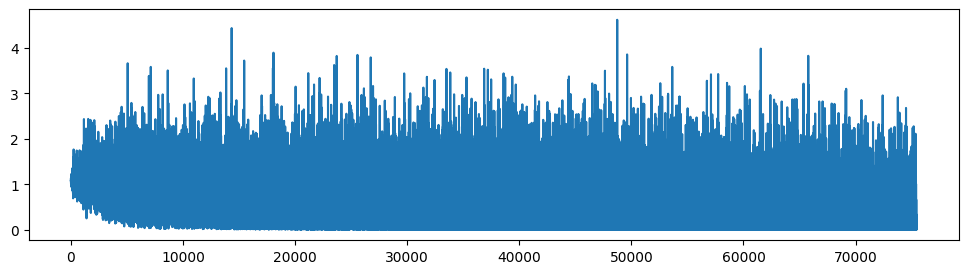

In [171]:
if losses_camera is not None:
    plt.figure(figsize=(12, 3))
    plt.plot(losses_camera)

# Submission

In [172]:
dataset_test = MovementDataset(f"{root_path}/test_data.csv")

def collate_fn(batch):
    data_padded = pad_sequence(batch, batch_first=True)
    return data_padded

test_loader = DataLoader(
    dataset_test,
    batch_size=64,
    shuffle=False,
    collate_fn=collate_fn
)

In [173]:
df_test = pd.read_csv(f"{root_path}/test_data.csv")
ids = df_test["IDSample"].unique()

In [174]:
subtask1_ans = []
for i in range(len(ids)):
    subtask1_ans.append(dataset_test.len_frames(i))

In [175]:
subtask2_ans, subtask3_ans = [], []

model_action.eval()
model_action.eval()
with torch.no_grad():
    for data in tqdm(test_loader):
        # move to device
        data = data.to(device)

        # forward once
        logits_cam = model_camera(data)
        logits_act = model_action(data)

        # softmax -> probabilities
        probs_act = F.softmax(logits_act, dim=-1)  # shape (B,5)
        probs_cam = F.softmax(logits_cam, dim=-1)  # shape (B,3)

        # argmax -> class indices
        batch_pred_act = probs_act.argmax(dim=1).cpu().tolist()      # 0–4
        batch_pred_cam = (probs_cam.argmax(dim=1) + 1).cpu().tolist()# 1–3

        subtask2_ans.extend(batch_pred_act)
        subtask3_ans.extend(batch_pred_cam)

100%|██████████| 22/22 [00:01<00:00, 21.08it/s]


In [176]:
subtask1 = pd.DataFrame({
    "datapointID": ids,
    "answer": subtask1_ans,
    "subtaskID": 1
})

subtask2 = pd.DataFrame({
    "datapointID": ids,
    "answer": subtask2_ans,
    "subtaskID": 2
})

subtask3 = pd.DataFrame({
    "datapointID": ids,
    "answer": subtask3_ans,
    "subtaskID": 3
})

In [177]:
submission = pd.concat([subtask1, subtask2, subtask3])
submission.head()

,datapointID,answer,subtaskID
0,3361,124,1
1,3362,78,1
2,3363,207,1
3,3364,66,1
4,3365,83,1


In [178]:
submission.to_csv("submission.csv", index=False)